# P0: Intro

<center><b>Machine Learning Project</b></center>
<br><center><b>Sharif University of Technology - Fall 2023</b></center>

<div style="text-align:justify">Hopefully, the course has been insightful for you till now. This notebook serves as a template for the project which involves training a sentiment analyzer neural network using the comments of a Persian website and fine-tuning it using the comments of another.<br><br>
The first website is Snappfood which is used by the people in Iran to order different kinds of food. The latter is Digikala, an online store for Iranians where people buy many things including smartphones, groceries, cars, and whatever you consider legal. Both websites provide users with ways to express their opinions about the products.<br><br>
A domain shift may be revealed to some degree when switching from Snappfood comments to the ones extracted from Digikala. This will be one of the challenges you will be faced with. So, beware of it!</div>

# P1: Exploring the Datasets (25 points)

Both of the datasets are added to the notebook. In this part, we want to explore their contents.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load both of the datasets

In [2]:
snappdf = pd.read_csv('SnappfoodData.csv', on_bad_lines='skip' , delimiter='\t')
digidf = pd.read_csv('DigikalaData.csv')

In [3]:
snappdf.head()

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0
3,NaN,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0
4,NaN,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0


In [4]:
digidf.head()

,Text,Score,Suggestion
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1
1,خرید این محصول رو توصیه میکنم,84,1
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1


In [5]:
snappdf.drop('Unnamed: 0', axis=1, inplace=True)
snappdf.dropna(inplace=True)
digidf.dropna(inplace=True)

Count the number of comments each dataset contains **(P1-1: 5 points)**

In [6]:
print('Number of comments in Snappfood dataset: ', len(snappdf))
print('Number of comments in Digikala dataset: ', len(digidf))

Number of comments in Snappfood dataset:  69480
Number of comments in Digikala dataset:  3261


Represent the distribution of comments in the Snappfood dataset in terms of being negative or positive **(P1-2: 5 points)**

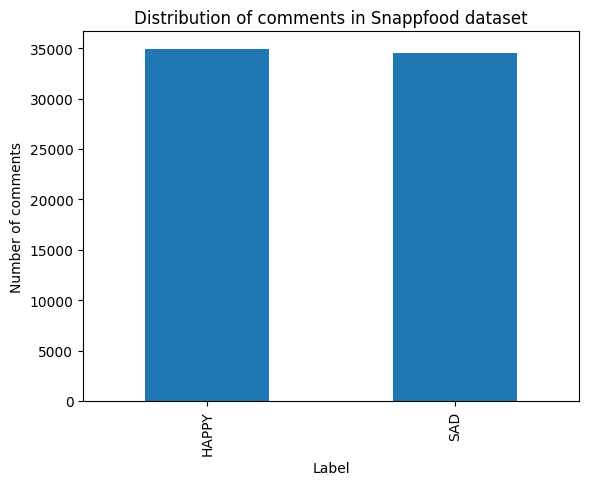

HAPPY    34916
SAD      34564
Name: label, dtype: int64


In [7]:
snappdf['label'].value_counts().plot(kind='bar')
plt.title('Distribution of comments in Snappfood dataset')
plt.xlabel('Label')
plt.ylabel('Number of comments')
plt.show()
print(snappdf['label'].value_counts())

Plot the logarithm of the frequency of words as a function of the logarithm of their rank to demonstrate the Zipf's law. <br>
Note: Don't panic! The Zipf's law can be found here: https://nlp.stanford.edu/IR-book/html/htmledition/zipfs-law-modeling-the-distribution-of-terms-1.html and can be easily understood. **(P1-3: 5 points)**

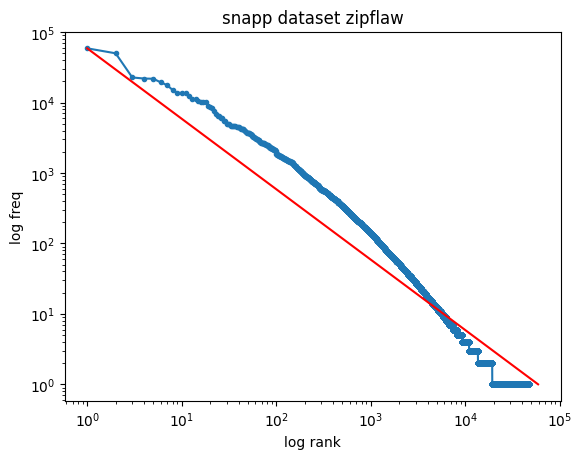

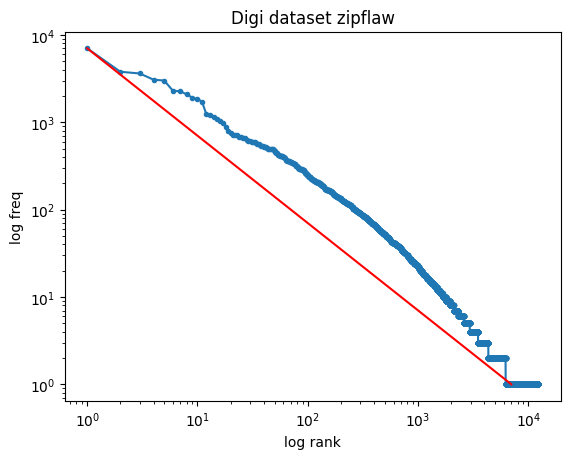

In [8]:
from collections import Counter
import math
import matplotlib.pyplot as plt
import seaborn as sns


def zipf_law(text, title):
    splited = text.str.split(expand=True).stack()
    counts = -splited.value_counts()
    freq = -counts[np.argsort(counts)]
    plt.loglog(np.arange(1, len(counts) + 1), freq, marker=".")
    plt.plot([1,freq[0]],[freq[0],1],color='r')
    plt.xlabel("log rank")
    plt.ylabel("log freq")
    plt.title(title)
    plt.show()
zipf_law(snappdf['comment'],"snapp dataset zipflaw")
zipf_law(digidf['Text'],"Digi dataset zipflaw")

Add a new column to the Digikala dataset indicating whether the comment was positive, negative, or neutral. This will be needed later for classification. <br>
Note: This can be done in many ways. You should the appropriate method. **(P1-4: 5 points)**

In [9]:
def label_digi(x):
  if x['Suggestion'] != 2 and x['Score']>= 70:
    return 'Positive'
  if x['Suggestion'] == 2 or x['Score']<30:
    return 'Negative'
  return 'Neutral'

In [10]:
digidf['label'] = digidf.apply(lambda x: label_digi(x), axis=1)
digidf.head()

,Text,Score,Suggestion,label
0,این اولین تجربه من برای خرید ایفون هست امروز...,100,1,Positive
1,خرید این محصول رو توصیه میکنم,84,1,Positive
2,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,60,1,Neutral
3,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,96,1,Positive
4,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,92,1,Positive


In [11]:
digidf['label'].value_counts()

Positive    1866
Neutral      845
Negative     550
Name: label, dtype: int64

Split each dataset into training, testing, and validation sets. **(P1-5: 5 points)**

In [12]:
from sklearn.model_selection import train_test_split
digi_train, digi_test = train_test_split(digidf, test_size=0.2, random_state=42)
digi_val, digi_test = train_test_split(digi_test, test_size=0.5, random_state=42)

snapp_train, snapp_test = train_test_split(snappdf, test_size=0.2, random_state=42)
snapp_val, snapp_test = train_test_split(snapp_test, test_size=0.5, random_state=42)

# P2: Preprocessing and Feature Extraction (20 points)

The goal of this part is to make the Snappfood dataset ready for the neural network to be trained with.<br>
Note: You can use many libraries including `NLTK`, `Spacy`, `Hazm`, `Parsivar`, `Stanza` etc.

In [13]:
# let's make the two datasets a little similar
digidf['comment'] = digidf['Text']
digidf.drop(columns=['Score','Suggestion','Text'],inplace=True)

In [14]:
digidf.head()

,label,comment
0,Positive,این اولین تجربه من برای خرید ایفون هست امروز...
1,Positive,خرید این محصول رو توصیه میکنم
2,Neutral,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...
3,Positive,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...
4,Positive,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...


Remove the unnecessary characters of the dataset. <br>
**(P2-1: 5 points)**

In [15]:
all_comments = ' '.join(snappdf['comment'].astype(str))
unique_characters = set(all_comments) # just wanted to see what we have here
print(unique_characters)

{'غ', 'ن', '^', 'C', '٧', '@', 'X', '/', '٩', 'y', 'م', '!', 'W', 'ء', '٫', '(', 'ا', 'E', 'l', 'ث', 'k', 'ع', '…', '<', 'ط', 's', '۲', 'F', 'ی', '۷', '٨', 'ت', '+', 'n', '.', '’', 'ف', '۹', 'ڀ', '٥', '٠', 'د', 'ۀ', 'و', "'", 'B', '١', 'ب', 'm', '۔', 'S', 'T', 'ؤ', '\\', '٦', 'v', '\u200e', 'i', 'o', 'P', '٤', 'ٔ', '٪', '۱', 'ڇ', 'd', 'أ', 'چ', '،', '٢', '۰', '&', '۴', '"', '∆', ',', '?', 'Y', 't', 'h', '۸', 'Z', 'ە', 'w', ')', ':', 'ذ', 'ک', 'c', ' ', '؛', '۵', '\u200b', 'e', 'K', 'H', 'j', '`', '\u202a', '\u202c', 'q', '٬', 'ى', '-', 'a', 'p', 'z', 'J', 'س', 'آ', '؟', 'ه', ';', 'ر', 'O', 'U', '\u061c', 'f', '=', 'u', 'R', '\u200f', '[', 'I', 'b', 'گ', 'x', '٣', 'ص', 'ظ', 'ش', 'ض', 'پ', 'ز', 'ق', 'N', 'M', '۳', 'D', 'L', 'ہ', 'خ', 'V', '\u200c', 'ة', 'A', 'r', '۶', 'ج', 'g', 'إ', '>', 'G', 'ڗ', 'ئ', 'ح', 'ل', 'ژ', 'ھ'}


In [16]:
import re
def keep_persian_english(text):
    cleaned_text = re.sub(r'[^a-zA-Zا-ی\s]', '', text)
    return cleaned_text
snappdf['cleaned_comment'] = snappdf['comment'].apply(keep_persian_english)
digidf['cleaned_comment'] = digidf['comment'].apply(keep_persian_english)

Normalize the dataset. <br>
Note: Check the result. For instance, if you do this correctly, you'll have a dataset containing just 1 type of space. **(P2-2: 5 points)**

If you want to include other preprocessing steps, put all of your code here.

In [ ]:
!pip install hazm

In [18]:
from hazm import Normalizer, word_tokenize, Stemmer

normalizer = Normalizer()
tokenizer = word_tokenize
stemmer = Stemmer()

snappdf['normalized_comment'] = snappdf['cleaned_comment'].apply(lambda x: normalizer.normalize(x))
snappdf['tokenized_comment'] = snappdf['normalized_comment'].apply(lambda x: tokenizer(x))
snappdf['text'] = snappdf['tokenized_comment'].apply(lambda x: [stemmer.stem(word) for word in x])

normalizer = Normalizer()
tokenizer = word_tokenize
stemmer = Stemmer()
digidf['normalized_comment'] = digidf['cleaned_comment'].apply(lambda x: normalizer.normalize(x))
digidf['tokenized_comment'] = digidf['normalized_comment'].apply(lambda x: tokenizer(x))
digidf['text'] = digidf['tokenized_comment'].apply(lambda x: [stemmer.stem(word) for word in x])


In [19]:
snappdf.head()

,comment,label,label_id,cleaned_comment,normalized_comment,tokenized_comment,text
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,"[واقعا, حیف, وقت, که, بنویسم, سرویس, دهیتون, ش...","[واقعا, حیف, وق, که, بنویس, سرویس, دهیتون, شده..."
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...,قرار بود ساعته برسه ولی نیم ساعت زودتر از موقع...,"[قرار, بود, ساعته, برسه, ولی, نیم, ساعت, زودتر...","[قرار, بود, ساعته, برسه, ول, ن, ساع, زود, از, ..."
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...,"[قیمت, این, مدل, اصلا, با, کیفیتش, سازگاری, ند...","[قیم, این, مدل, اصلا, با, کیفیت, سازگار, نداره..."
3,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,HAPPY,0.0,عالللی بود همه چه درست و به اندازه و کیفیت خوب...,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...,"[عالی, بود, همه, چه, درست, و, به, اندازه, و, ک...","[عال, بود, همه, چه, درس, و, به, اندازه, و, کیف..."
4,شیرینی وانیلی فقط یک مدل بود.,HAPPY,0.0,شیرینی وانیلی فقط یک مدل بود,شیرینی وانیلی فقط یک مدل بود,"[شیرینی, وانیلی, فقط, یک, مدل, بود]","[شیرین, وانیل, فقط, یک, مدل, بود]"


In [20]:
digidf.head()

,label,comment,cleaned_comment,normalized_comment,tokenized_comment,text
0,Positive,این اولین تجربه من برای خرید ایفون هست امروز...,این اولین تجربه من برای خرید ایفون هست امروز...,این اولین تجربه من برای خرید ایفون هست امروز ب...,"[این, اولین, تجربه, من, برای, خرید, ایفون, هست...","[این, اولین, تجربه, من, برا, خرید, ایفون, هس, ..."
1,Positive,خرید این محصول رو توصیه میکنم,خرید این محصول رو توصیه میکنم,خرید این محصول رو توصیه می‌کنم,"[خرید, این, محصول, رو, توصیه, می‌کنم]","[خرید, این, محصول, رو, توصیه, می‌کن]"
2,Neutral,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ندیدم,ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ندیدم,"[ساله, این, گوشی, رو, دارم, هیچ, نقطه, ضعفی, ا...","[ساله, این, گوش, رو, دار, هیچ, نقطه, ضعف, از, ..."
3,Positive,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,سلام خدمت دوستان این گوشی از همه نظر عالی کیفی...,"[سلام, خدمت, دوستان, این, گوشی, از, همه, نظر, ...","[سلا, خدم, دوس, این, گوش, از, همه, نظر, عال, ک..."
4,Positive,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,"[سلام, دوستانی, که, نگران, شکستن, صفحه, نمایش,...","[سلا, دوستان, که, نگر, شکستن, صفحه, نما, هستند..."


In [21]:
snappdf = snappdf.drop(['normalized_comment', 'tokenized_comment', 'cleaned_comment','label'], axis=1)
digidf = digidf.drop(['normalized_comment','tokenized_comment','cleaned_comment'],axis=1)

In [22]:
snappdf.drop(['comment'],axis=1,inplace=True)


In [23]:
snappdf.rename(columns={'label_id':'label'},inplace=True)

In [24]:
digidf.head()

,label,comment,text
0,Positive,این اولین تجربه من برای خرید ایفون هست امروز...,"[این, اولین, تجربه, من, برا, خرید, ایفون, هس, ..."
1,Positive,خرید این محصول رو توصیه میکنم,"[خرید, این, محصول, رو, توصیه, می‌کن]"
2,Neutral,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,"[ساله, این, گوش, رو, دار, هیچ, نقطه, ضعف, از, ..."
3,Positive,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,"[سلا, خدم, دوس, این, گوش, از, همه, نظر, عال, ک..."
4,Positive,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,"[سلا, دوستان, که, نگر, شکستن, صفحه, نما, هستند..."


In [25]:
from hazm import Lemmatizer
lemmatizer = Lemmatizer()
snappdf['text'] = snappdf['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
lemmatizer = Lemmatizer()
digidf['text'] = digidf['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [26]:
from hazm import stopwords_list
stopwords = set(stopwords_list())
snappdf['text'] = snappdf['text'].apply(lambda x: [word for word in x if word not in stopwords])
digidf['text'] = digidf['text'].apply(lambda x: [word for word in x if word not in stopwords])
digidf.head()

,label,comment,text
0,Positive,این اولین تجربه من برای خرید ایفون هست امروز...,"[تجربه, برا, خرید, ایفون, هس, امروز, ب, دس, رس..."
1,Positive,خرید این محصول رو توصیه میکنم,"[خرید, محصول, توصیه, می‌کن]"
2,Neutral,1 ساله این گوشی رو دارم هیچ نقطه ضعفی ازش ند...,"[گوش, نقطه, ضعف, دید#بین]"
3,Positive,سلام خدمت دوستان این گوشی از همه نظر عالی کیف...,"[سلا, خدم, دوس, گوش, عال, کیف, ساخ, سرع, کیف, ..."
4,Positive,سلام دوستانی که نگران شکستن صفحه نمایش هستند ا...,"[سلا, دوستان, نگر, شکستن, صفحه, نما, #هست, بدو..."


In [27]:
snappdf['text'] = snappdf['text'].apply(lambda x: ' '.join(x))
digidf['text'] = digidf['text'].apply(lambda x: ' '.join(x))

Extract features from the Snappfood dataset
<br> Note: You should use both of the following methods, and compare the results at the end.
- Method 1 (Classic): Use `CountVectorizer` or `TF-IDF`.
- Method 2 (Modern): Use `Word2Vec`, `FastText`, `GloVe`, `Doc2Vec` or train your own `Embedding` Layer.

If you choose to train your own `Embedding`s, you'll just need to specify an ID for each word remaining in your dataset. **(P2-3: 10 points)**

In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Method 1:

In [47]:

train_df, test_df = train_test_split(snappdf, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

vectorizer = CountVectorizer(max_features=300)
snapp_X_train = vectorizer.fit_transform(train_df['text'])
snapp_X_val = vectorizer.transform(val_df['text'])
snapp_X_test = vectorizer.transform(test_df['text'])

snapp_y_train = train_df['label']
snapp_y_val = val_df['label']
snapp_y_test = test_df['label']

In [78]:
from sklearn.preprocessing import LabelEncoder

labels_str = digidf['label'].values

label_encoder = LabelEncoder()
labels_numeric = label_encoder.fit_transform(labels_str)
digidf['label'] = labels_numeric
digidf.head()

,label,text
0,2,"[تجربه, برا, خرید, ایفون, هس, امروز, ب, دس, رس..."
1,2,"[خرید, محصول, توصیه, می‌کن]"
2,1,"[گوش, نقطه, ضعف, دید#بین]"
3,2,"[سلا, خدم, دوس, گوش, عال, کیف, ساخ, سرع, کیف, ..."
4,2,"[سلا, دوستان, نگر, شکستن, صفحه, نما, #هست, بدو..."


In [81]:
digiX = vectorizer.transform(digidf['text'].apply(lambda x: ' '.join(x)))
digi_cvdf = pd.DataFrame(digiX.toarray(), columns=vectorizer.get_feature_names_out())

# P3: Training and Initial Evaluation (20 points)

Define an architecture for your neural network. **(P3-1: 5 points)**

In [48]:
max_words = 10000
embedding_dim = 50
# model = Sequential()
# model.add(Embedding(max_words, embedding_dim, input_length=snapp_X_train.shape[1]))
# model.add(Bidirectional(LSTM(64, return_sequences=True)))
# model.add(Bidirectional(LSTM(64)))
# model.add(Dense(1, activation='sigmoid'))

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=snapp_X_train.shape[1]))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 300, 50)           500000    
                                                                 
 bidirectional_16 (Bidirect  (None, 128)               58880     
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 559009 (2.13 MB)
Trainable params: 559009 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Train the network on the Snappfood dataset, while monitoring its performance on the validation set. **(P3-2: 5 points)**

In [49]:
epochs = 5
batch_size = 32
history = model.fit(snapp_X_train.toarray(), snapp_y_train, epochs=epochs,\
                    batch_size=batch_size, validation_data=(snapp_X_val.toarray(), snapp_y_val))

Epoch 1/5
1737/1737 [==============================] - 51s 28ms/step - loss: 0.6599 - accuracy: 0.6001 - val_loss: 0.6392 - val_accuracy: 0.6405
Epoch 2/5
1737/1737 [==============================] - 47s 27ms/step - loss: 0.6369 - accuracy: 0.6362 - val_loss: 0.6287 - val_accuracy: 0.6494
Epoch 3/5
1737/1737 [==============================] - 46s 27ms/step - loss: 0.6279 - accuracy: 0.6457 - val_loss: 0.6297 - val_accuracy: 0.6393
Epoch 4/5
1737/1737 [==============================] - 45s 26ms/step - loss: 0.6203 - accuracy: 0.6537 - val_loss: 0.6196 - val_accuracy: 0.6618
Epoch 5/5
1737/1737 [==============================] - 46s 26ms/step - loss: 0.6247 - accuracy: 0.6496 - val_loss: 0.6188 - val_accuracy: 0.6662


Evaluate the performance of your network on the Snappfood testing set. **(P3-3: 5 points)**

In [44]:
test_loss, test_accuracy = model.evaluate(snapp_X_test.toarray(), snapp_y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8173


Save the weights of the neural network and its architecture seperately in the notebook's output folder (`/kaggle/working/`). **(P3-4: 5 points)**

In [45]:
torch.save(model.state_dict(), 'snapp_model_weights.pth')
torch.save(model, 'snapp_model_architecture.pth')

# Method 2

In [35]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2024-01-25 21:06:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-01-25 21:06:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-01-25 21:06:25--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [36]:
embedding_dim = 100
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['text'])

word_index = tokenizer.word_index

glove_path = 'glove.6B.100d.txt'
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [45]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Tokenize and pad sequences for training, validation, and test sets
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_val = tokenizer.texts_to_sequences(val_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

X_train = pad_sequences(X_train, maxlen=max_len)
X_val = pad_sequences(X_val, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = train_df['label']
y_val = val_df['label']
y_test = test_df['label']

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 bidirectional_14 (Bidirect  (None, 100, 128)          84480     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1183425 (4.51 MB)
Trainable params: 183425 (716.50 KB)
Non-trainable params: 1000000 (3.81 MB)
_________________________________________________________________


In [46]:
epochs = 10
batch_size = 64
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/10
869/869 [==============================] - 39s 35ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 2/10
869/869 [==============================] - 21s 24ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6930 - val_accuracy: 0.4999
Epoch 3/10
869/869 [==============================] - 21s 24ms/step - loss: 0.6927 - accuracy: 0.5024 - val_loss: 0.6927 - val_accuracy: 0.5007
Epoch 4/10
869/869 [==============================] - 21s 24ms/step - loss: 0.6924 - accuracy: 0.5056 - val_loss: 0.6928 - val_accuracy: 0.5006
Epoch 5/10
869/869 [==============================] - 21s 24ms/step - loss: 0.6919 - accuracy: 0.5019 - val_loss: 0.6927 - val_accuracy: 0.5006
Epoch 6/10
869/869 [==============================] - 21s 24ms/step - loss: 0.6911 - accuracy: 0.5069 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 7/10
869/869 [==============================] - 21s 24ms/step - loss: 0.6910 - accuracy: 0.5028 - val_loss: 0.6939 - val_accuracy:

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# P4: Fine-tuning and Evaluation (35 points)

In this part, we will fine-tune the previously trained network on the comments extracted from Digikala.

Load the neural network along with its weights **(P4-1: 5 points)**

Change the architecture of the network (the last layer) to make it appropriate for classifying the sentiment of a comment in one of the previously mentioned three classes: positive, negative, or neutral. **(P4-2: 5 points)**

In [109]:
labels = digidf['label'].values
labels = F.one_hot(torch.tensor(labels), num_classes=3)

# Split the dataset into train, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    digi_cvdf, labels, test_size=0.2, random_state=42, stratify=labels
)

train_data, val_data, train_labels, val_labels = train_test_split(
    train_data, train_labels, test_size=0.1, random_state=42, stratify=train_labels
)

# Convert data to PyTorch tensors
train_data_tensor = torch.tensor(train_data.values, dtype=torch.float32)
val_data_tensor = torch.tensor(val_data.values, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data.values, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

<ipython-input-109-ac470c22a8f4>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
<ipython-input-109-ac470c22a8f4>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
<ipython-input-109-ac470c22a8f4>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)


In [117]:
train_dataset = CustomDataset(train_data_tensor, train_labels_tensor)
val_dataset = CustomDataset(val_data_tensor, val_labels_tensor)
test_dataset = CustomDataset(test_data_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Extract features from the Digikala dataset.<br>
Note: Pay attention to the fact that your features are the same as the ones you extracted from the Snappfood dataset. You just need to use the same method for the new dataset. For instance, if you consider the `CountVectorizer` as your feature extractor, the set of the words for which you'll count the frequency will not change! **(P4-3: 15 points)**

Fine-tune the network on the training set associated with the Digikala dataset, while monitoring its performance on the corresponding validation set.<br>
Note: The process of fine-tuning should follow one of these methods:
- Method 1: Fix the weights for all layers expect the last one.
- Method 2: Use a really small learning rate for all layers except the last one.

**(P4-4: 5 points)**

In [114]:
pretrained_model = BiLSTM(input_size, hidden_size, output_size)
pretrained_model.load_state_dict(torch.load('best_model.pth'))

# Modify the output layer to match the number of classes in digidf
pretrained_model.fc = nn.Linear(hidden_size * 2, 3)  # 3 output neurons for 3 classes
pretrained_model.softmax = nn.Softmax(dim=1)  # Softmax activation for multi-class classification

# Freeze the pre-trained layers
for param in pretrained_model.lstm.parameters():
    param.requires_grad = False



In [151]:
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001)


In [152]:
def validate(model, val_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(labels,1)
            total += len(labels)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Validation Accuracy: {accuracy:.4f}')
    return accuracy



In [153]:
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = pretrained_model(inputs)

        # Calculate the loss
        loss = nn.CrossEntropyLoss()(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    val_accuracy = validate(pretrained_model, val_loader)
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(pretrained_model.state_dict(), 'new_fine_tune.pth')


Validation Accuracy: 0.5632
Validation Accuracy: 0.5709
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670
Validation Accuracy: 0.5670


Evaluate the performance of the neural network on the testing set you have extracted from the Digikala dataset. **(P4-5: 5 points)**

In [154]:
val_accuracy = validate(pretrained_model, test_loader)

Validation Accuracy: 0.6172


In [156]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [155]:
from sklearn.metrics import f1_score


pretrained_model.eval()
all_predicted = []
all_true_labels = []

with torch.no_grad():
    for inputs, onehot_labels in test_loader:
        outputs = pretrained_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, true_labels = torch.max(onehot_labels, 1)

        all_predicted.extend(predicted.cpu().numpy())
        all_true_labels.extend(true_labels.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_true_labels, all_predicted, average='weighted')
print(f'Test F1 Score: {f1:.4f}')


Test F1 Score: 0.5532


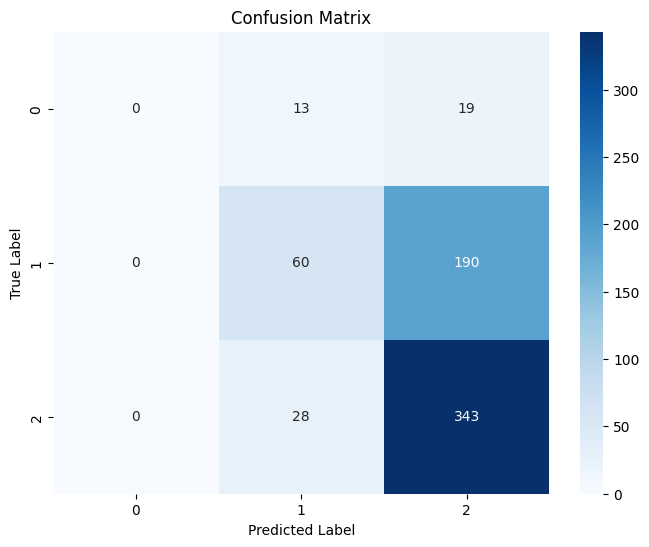

In [157]:
conf_matrix = confusion_matrix(all_true_labels, all_predicted)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()